IMPORT LIBRARY

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB

LOAD DATASET

In [50]:
df = pd.read_csv('Coffe_sales.csv')

print("5 Baris Awal Dataset:")
print(df.head())
print("\nInformasi Tipe Data:")
df.info()

5 Baris Awal Dataset:
   hour_of_day cash_type  money    coffee_name Time_of_Day Weekday Month_name  \
0           10      card   38.7          Latte     Morning     Fri        Mar   
1           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3           13      card   28.9      Americano   Afternoon     Fri        Mar   
4           13      card   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort        Date             Time  
0            5          3  2024-03-01  10:15:50.520000  
1            5          3  2024-03-01  12:19:22.539000  
2            5          3  2024-03-01  12:20:18.089000  
3            5          3  2024-03-01  13:46:33.006000  
4            5          3  2024-03-01  13:48:14.626000  

Informasi Tipe Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       No

INFO DATA

In [51]:
print("Info Dataset Awal:")
df.info()

Info Dataset Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


DATA CLEANING 

In [52]:
missing_value = df.isnull().sum()
print(f"\nJumlah Missing Value Sebelum Cleaning: \n{missing_value}")

duplicates = df.duplicated().sum()
print(f"\nJumlah baris duplikat: {duplicates}")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplikat telah dihapus.")

df['Date'] = pd.to_datetime(df['Date'])
print("\nTipe data 'Date' berhasil diubah ke datetime.")


Jumlah Missing Value Sebelum Cleaning: 
hour_of_day    0
cash_type      0
money          0
coffee_name    0
Time_of_Day    0
Weekday        0
Month_name     0
Weekdaysort    0
Monthsort      0
Date           0
Time           0
dtype: int64

Jumlah baris duplikat: 0

Tipe data 'Date' berhasil diubah ke datetime.


VISUALISASI EDA

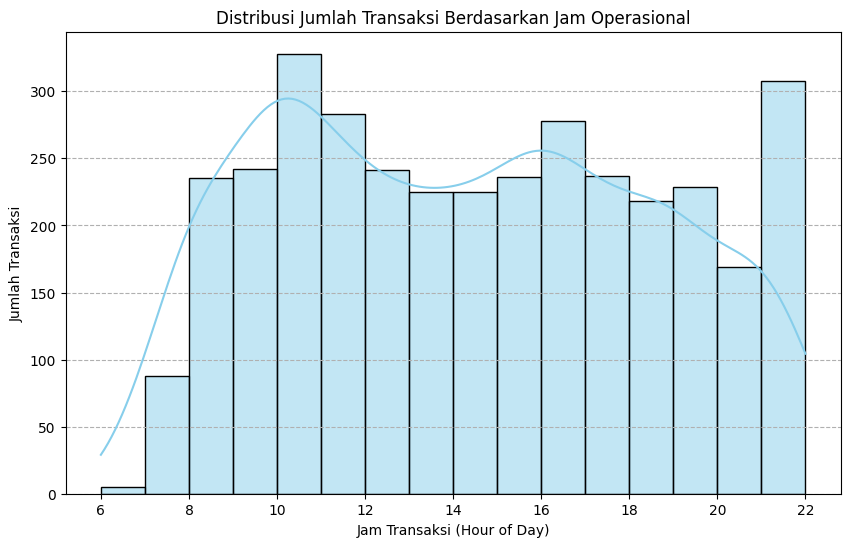

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31040\3903072476.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


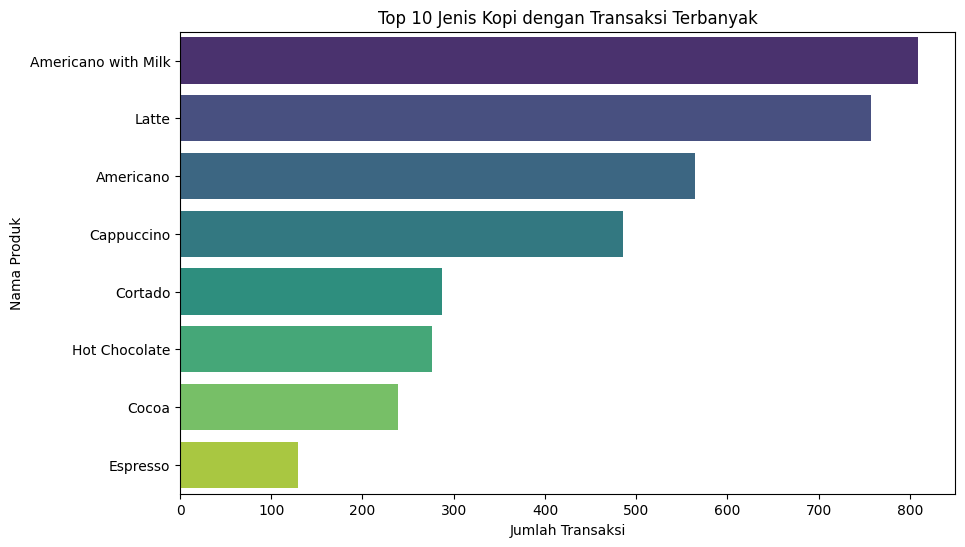

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31040\3903072476.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Weekday', order=day_order_abbr, palette='viridis')


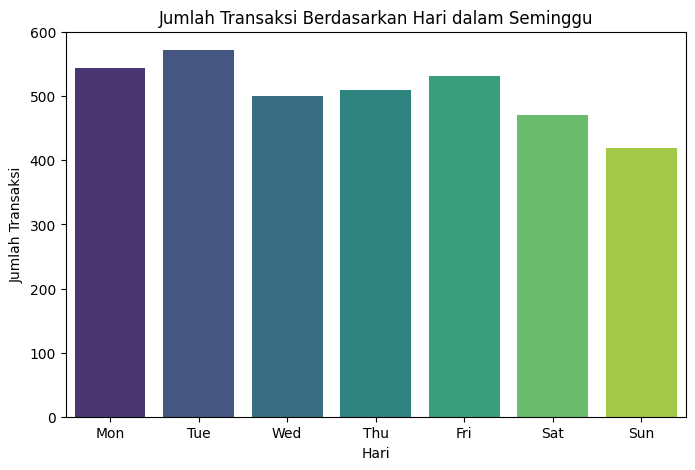

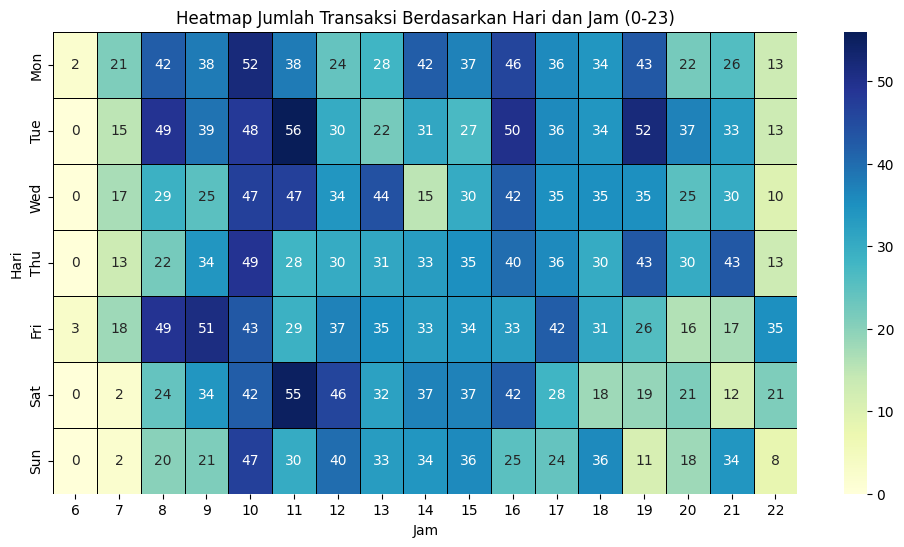

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='hour_of_day', bins=16, kde=True, color='skyblue')
plt.title('Distribusi Jumlah Transaksi Berdasarkan Jam Operasional')
plt.xlabel('Jam Transaksi (Hour of Day)')
plt.ylabel('Jumlah Transaksi')
plt.grid(axis='y', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
top_products = df['coffee_name'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Jenis Kopi dengan Transaksi Terbanyak')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Nama Produk')
plt.show()

day_order_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Weekday', order=day_order_abbr, palette='viridis')
plt.title('Jumlah Transaksi Berdasarkan Hari dalam Seminggu')
plt.xlabel('Hari')
plt.ylabel('Jumlah Transaksi')
plt.show()


df_heatmap_hourly = df.groupby(['Weekday', 'hour_of_day']).size().unstack(fill_value=0)

order_day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_heatmap_hourly = df_heatmap_hourly.reindex(order_day)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap_hourly, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5, linecolor='black')
plt.title('Heatmap Jumlah Transaksi Berdasarkan Hari dan Jam (0-23)')
plt.ylabel('Hari')
plt.xlabel('Jam')
plt.show()

DATA PREPARATION

In [54]:
df_agg = df.groupby(['Date', 'hour_of_day']).agg({
    'coffee_name': 'count',          
    'money': 'mean',                 
    'cash_type': lambda x: (x == 'card').mean()  
}).reset_index()

df_agg.rename(columns={
    'coffee_name': 'order_count',
    'money': 'avg_ticket_size',
    'cash_type': 'card_ratio'
}, inplace=True)

df_agg['day_name'] = df_agg['Date'].dt.day_name()
df_agg['month'] = df_agg['Date'].dt.month

threshold = df_agg['order_count'].quantile(0.75)
print(f"Threshold Peak Hour: > {int(threshold)} transaksi/jam")

df_agg['is_peak_hour'] = (df_agg['order_count'] > threshold).astype(int)

print("\nPreview Data Baru:")
display(df_agg.head())

Threshold Peak Hour: > 2 transaksi/jam

Preview Data Baru:


,Date,hour_of_day,order_count,avg_ticket_size,card_ratio,day_name,month,is_peak_hour
0,2024-03-01,10,1,38.7,1.0,Friday,3,0
1,2024-03-01,12,2,38.7,1.0,Friday,3,0
2,2024-03-01,13,2,33.8,1.0,Friday,3,0
3,2024-03-01,15,1,33.8,1.0,Friday,3,0
4,2024-03-01,16,1,38.7,1.0,Friday,3,0


ENCODING

In [55]:
df_model = pd.get_dummies(df_agg, columns=['day_name'], drop_first=True)

print("Kolom setelah One-Hot Encoding:")
print(df_model.columns.tolist())

Kolom setelah One-Hot Encoding:
['Date', 'hour_of_day', 'order_count', 'avg_ticket_size', 'card_ratio', 'month', 'is_peak_hour', 'day_name_Monday', 'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday', 'day_name_Tuesday', 'day_name_Wednesday']


Analisis Korelasi Fitur (Correlation Heatmap) pengaruh paling kuat terhadap `is_peak_hour`.

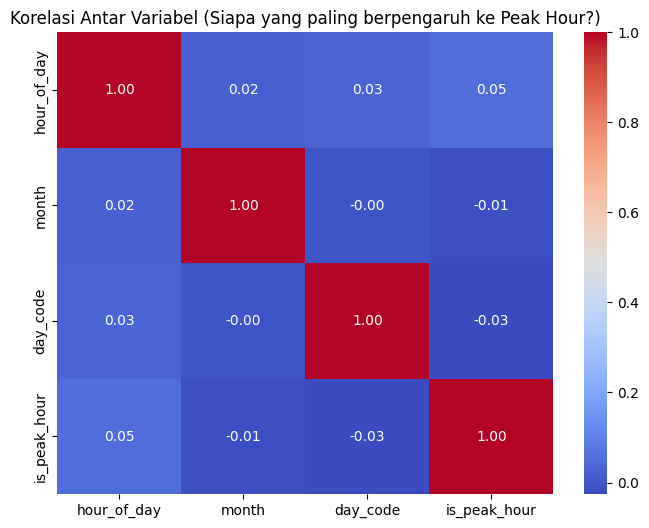

In [56]:
le = LabelEncoder()
df_agg['day_code'] = le.fit_transform(df_agg['day_name'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_agg[['hour_of_day', 'month', 'day_code', 'is_peak_hour']].corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f")

plt.title('Korelasi Antar Variabel (Siapa yang paling berpengaruh ke Peak Hour?)')
plt.show()

SPLITTING

In [57]:
X = df_model.drop(columns=['is_peak_hour', 'order_count', 'Date'])
y = df_model['is_peak_hour']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Data siap! Ukuran Training:", X_train.shape)

Data siap! Ukuran Training: (1625, 10)


STANDARISASI 

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

LATIH MODEL NAIVE BAYES

In [66]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Akurasi Naive Bayes:", accuracy_score(y_test, y_pred_nb))

Akurasi Naive Bayes: 0.8255528255528255


LATIH MODEL RANDOM FOREST

In [67]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Akurasi Random Forest:", accuracy_score(y_test, y_pred_rf))

Akurasi Random Forest: 0.8427518427518428


PERBANDINGAN ANTARA NAIVE BAYES DAN RANDOM FOREST


=== LAPORAN PERBANDINGAN ===

[1] Classification Report NAIVE BAYES:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       336
           1       0.00      0.00      0.00        71

    accuracy                           0.83       407
   macro avg       0.41      0.50      0.45       407
weighted avg       0.68      0.83      0.75       407


[2] Classification Report RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       336
           1       0.59      0.32      0.42        71

    accuracy                           0.84       407
   macro avg       0.73      0.64      0.66       407
weighted avg       0.82      0.84      0.82       407



c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

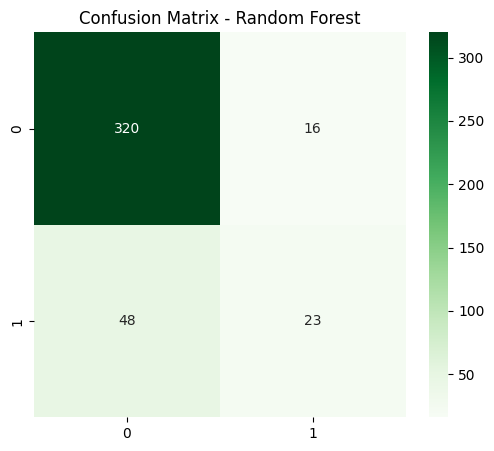

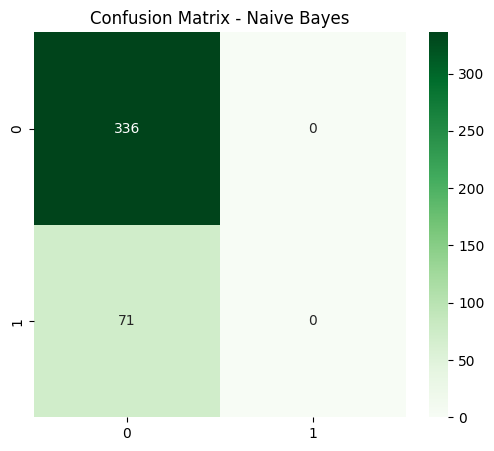

In [ ]:
print("\n=== LAPORAN PERBANDINGAN ===")
print("\n[1] Classification Report NAIVE BAYES:")
print(classification_report(y_test, y_pred_nb))

print("\n[2] Classification Report RANDOM FOREST:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

FEATURE IMPORTANCE

In [71]:
print("--- Feature Importance ---")

importances = rf_model.feature_importances_
feature_names = X.columns 

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Score': importances
})

feature_importance_df = feature_importance_df.sort_values(
    by='Importance Score', ascending=False
).reset_index(drop=True)

print(feature_importance_df)

--- Feature Importance ---
              Feature  Importance Score
0     avg_ticket_size          0.382108
1         hour_of_day          0.293961
2               month          0.212826
3   day_name_Saturday          0.021769
4    day_name_Tuesday          0.021542
5   day_name_Thursday          0.018461
6     day_name_Monday          0.017468
7  day_name_Wednesday          0.016324
8     day_name_Sunday          0.015541
9          card_ratio          0.000000


VISUALISASI FEATURE IMPORTANCE

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31040\2156272138.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


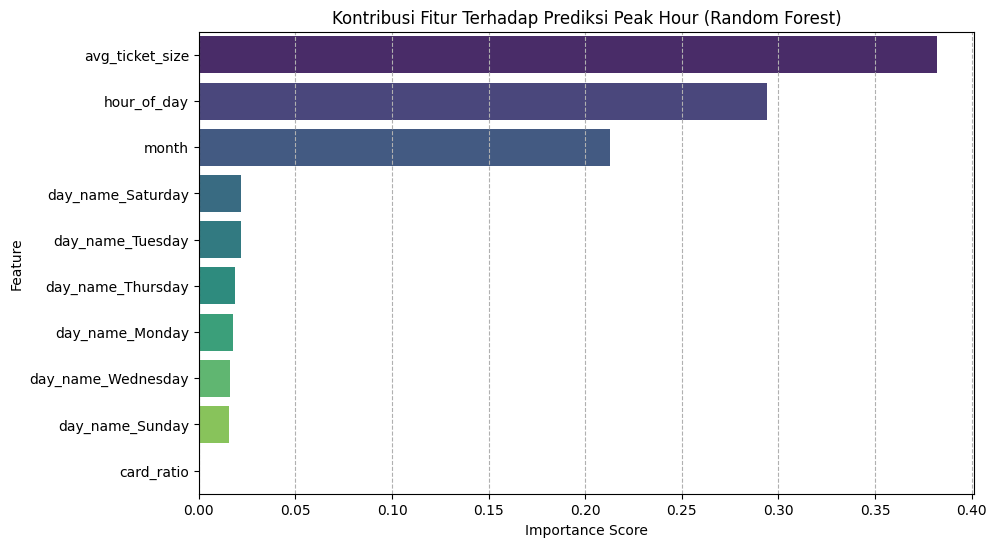

In [64]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance Score',
    y='Feature',
    data=feature_importance_df,
    palette='viridis' 
)
plt.title('Kontribusi Fitur Terhadap Prediksi Peak Hour (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--')
plt.show()